In [2]:
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler import lib

import sys
import os

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.model import Model
from src.functions import *

In [3]:
#Merge the results from the files in list. The files need to have the same dimension
def loadArray(fileNames="temp", mean=True):
    if type(fileNames) is list:
        file = open(fileNames[0], "rb")
        array = np.load(file)
        file.close()
        for fn in fileNames[1:]:
            file = open(fn, "rb")
            conAcc = np.load(file)
            array = np.concatenate((array, conAcc), axis=1)
            file.close()
        
    else:
        file = open(fileNames, "rb")
        array = np.load(file)
        file.close()

    return array

def displayPlot(data, ax, n_epochs, title="", xLabel="", ylabel="", logarithmic = False, legend = False):
    ax.plot(np.linspace(0, n_epochs, len(data)), data)
    if logarithmic:
        ax.set_yscale('log')
    if legend:
        ax.set_label(legend)
        ax.legend()
    ax.set(xlabel=xLabel, ylabel=ylabel)
    ax.set_title(title)

#Assumes models are saved in standard format
def displayResults(baseDirectory, modelName, displayDefault = True, displayRandom = False, consideredVersions = [1,2,3] ,figsize=(14,6), n_epochs = 50000):
    fig, axs = plt.subplots(1,2, figsize=figsize)
    legend = []
    for v in consideredVersions:
        if displayDefault:
            legend.append("Default Weights n="+str(v*5))
            loss = loadArray(baseDirectory + modelName +"_loss_v"+str(v))
            logloss = np.log10(loss+1)
            axs[0].plot(np.linspace(0, n_epochs, len(loss)), logloss)
            val = loadArray(baseDirectory + modelName +"_val_v"+str(v))
            axs[1].plot(np.linspace(0, n_epochs, len(val)), val)

        if displayRandom:
            legend.append("Random Weights n="+str(v*5))
            loss = loadArray(baseDirectory + "random_" + modelName +"_loss_v"+str(v))
            logloss = np.log10(loss+1)
            axs[0].plot(np.linspace(0, n_epochs, len(loss)), logloss)
            val = loadArray(baseDirectory + "random_" + modelName +"_val_v"+str(v))
            axs[1].plot(np.linspace(0, n_epochs, len(val)), val)

    axs[0].set_title("Loss [log(loss+1)]")
    axs[0].set(xlabel="Epochs", ylabel="Logarithmic Loss")
    axs[0].legend(legend)
    axs[1].set_title("Validation Accuracy")
    axs[1].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1].legend(legend)
    fig.suptitle(modelName)

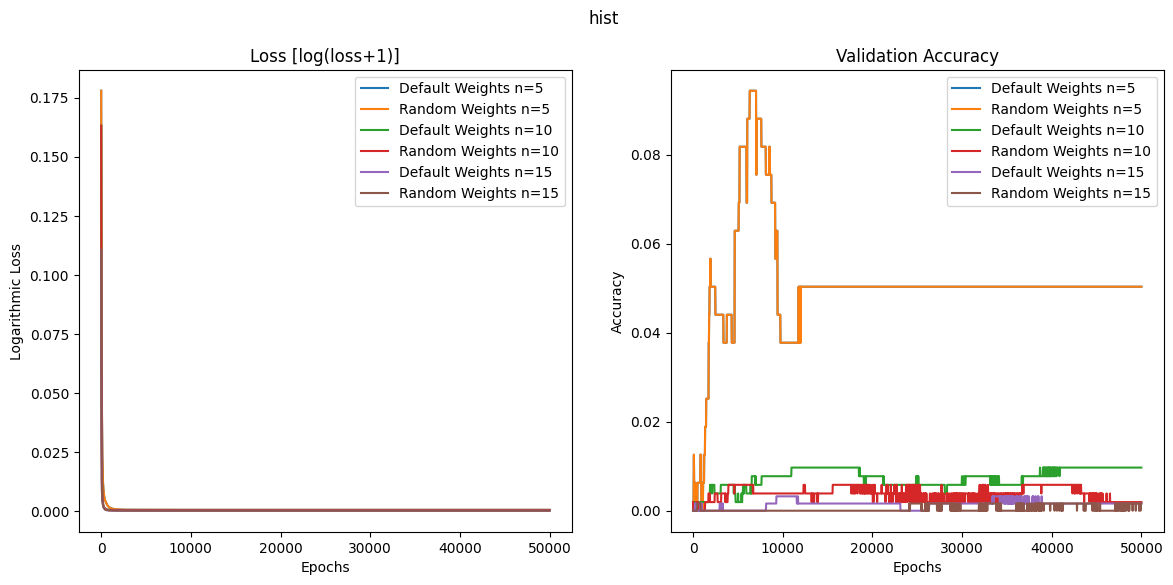

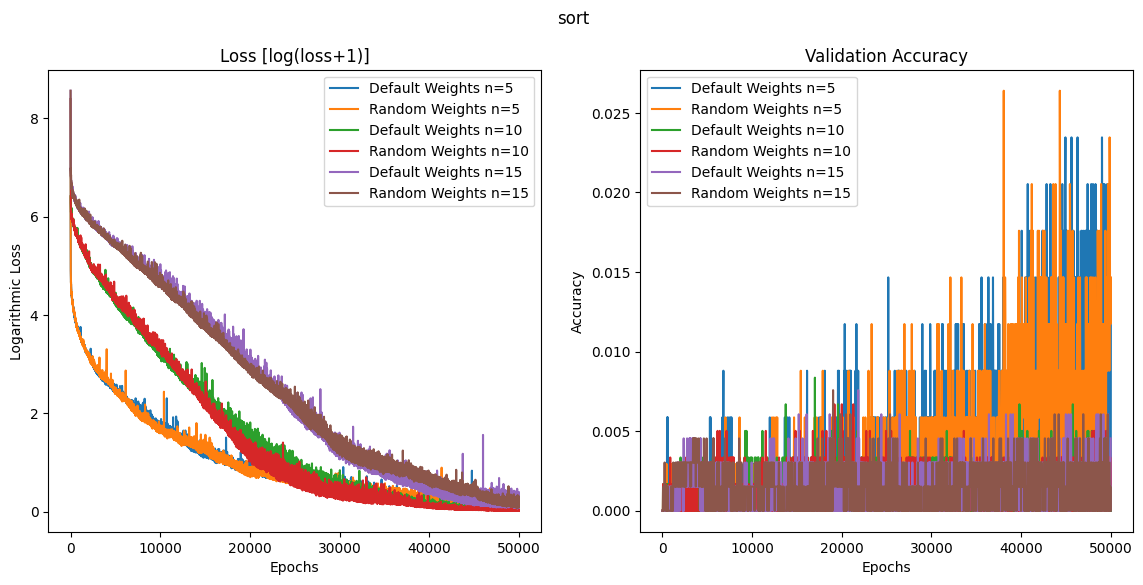

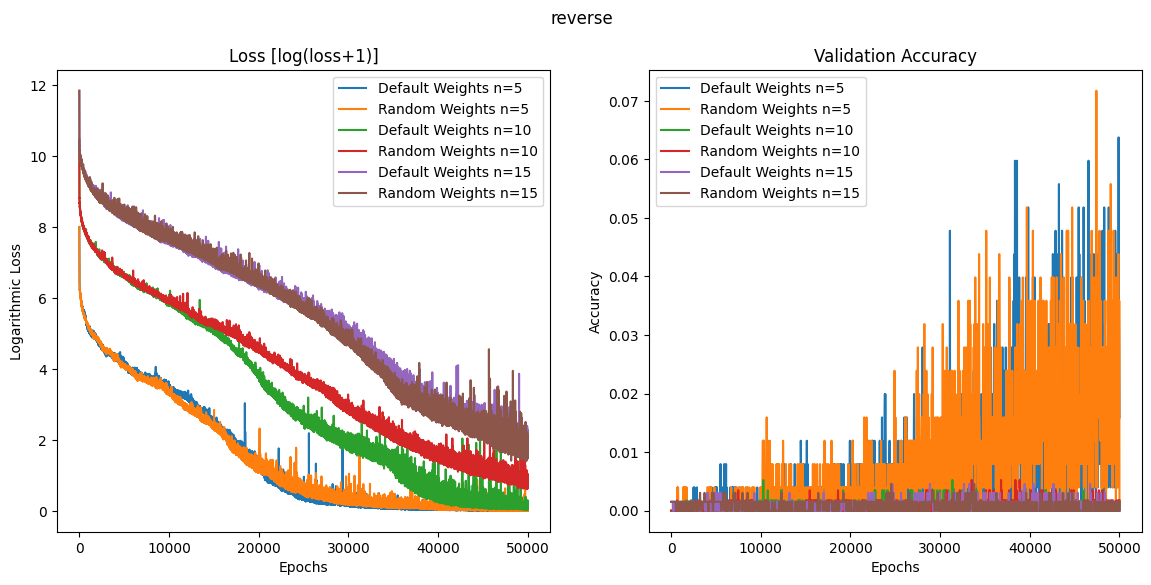

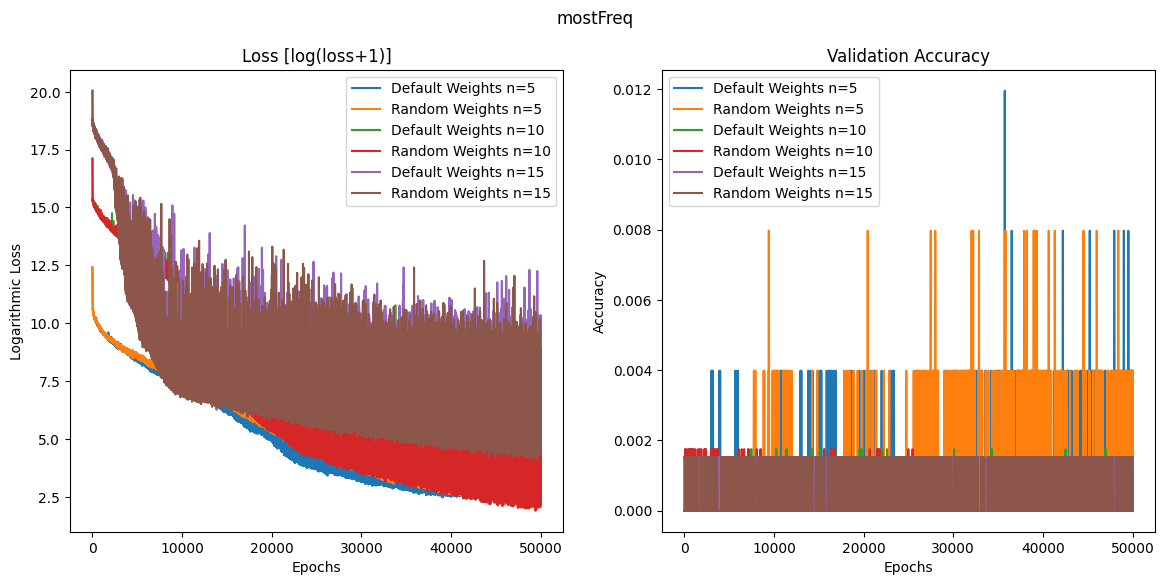

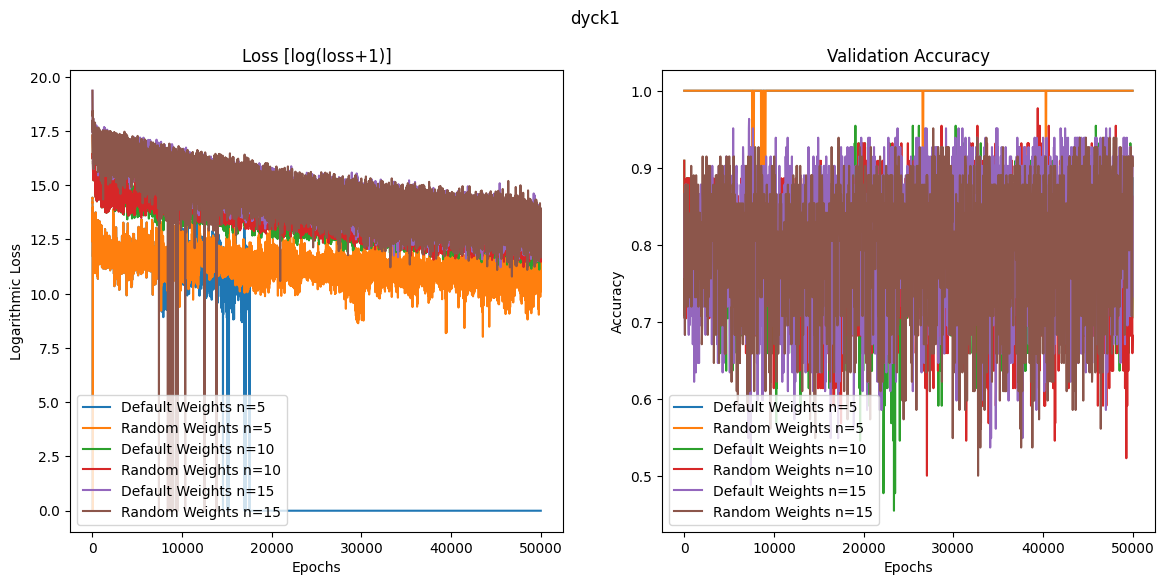

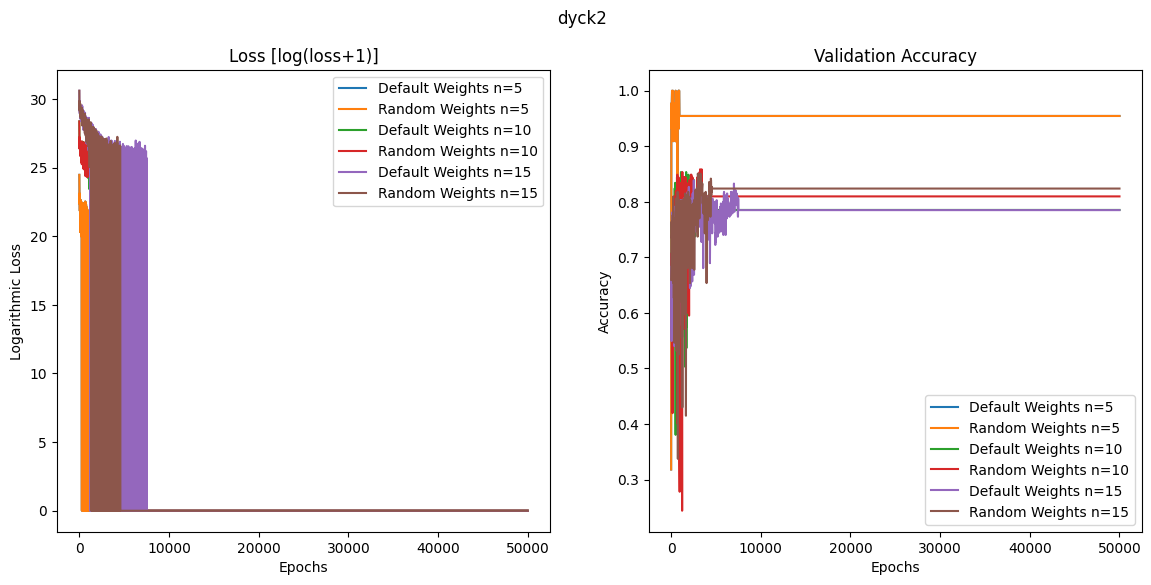

In [93]:
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/finalOvertraining/overTraining/"
displayResults(baseDirectory, "hist", displayRandom=True)
displayResults(baseDirectory, "sort", displayRandom=True)
displayResults(baseDirectory, "reverse", displayRandom=True)
displayResults(baseDirectory, "mostFreq", displayRandom=True)
displayResults(baseDirectory, "dyck1", displayRandom=True)
displayResults(baseDirectory, "dyck2", displayRandom=True)

In [62]:
data = np.ndarray(0)
print(data)
data = np.concat([data.reshape(-1, len(data)), np.arange(5).reshape(1,5)], axis=-1).reshape(-1, 5)
print(data)
data = np.concat([data, np.arange(5).reshape(1,5)], axis=-1).reshape(-1, 5)
print(data, data.shape)

[]


ValueError: cannot reshape array of size 0 into shape (0)

# Display all the results from overtraining

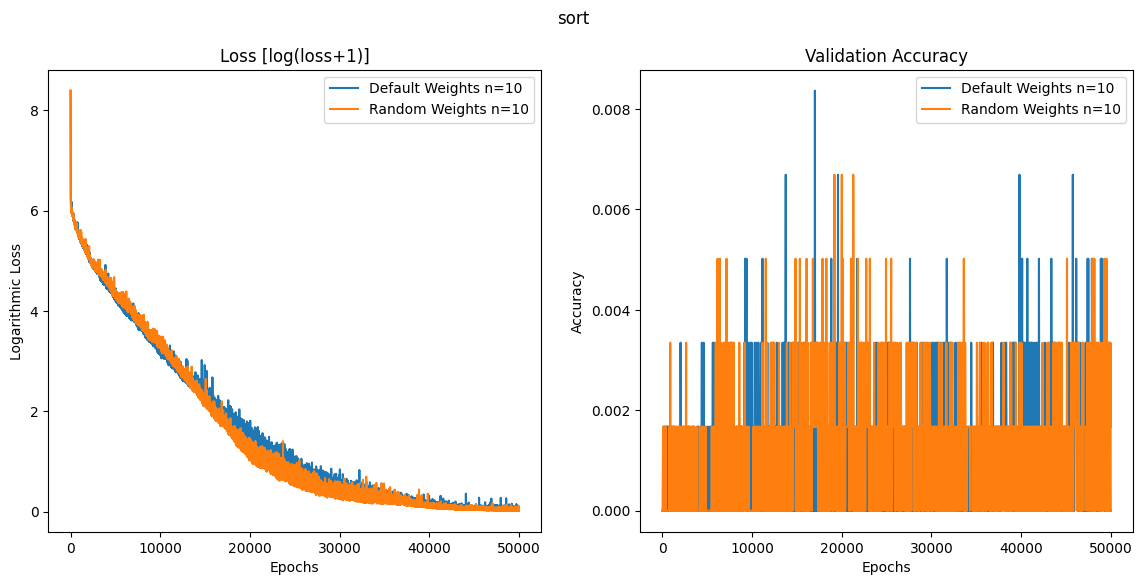

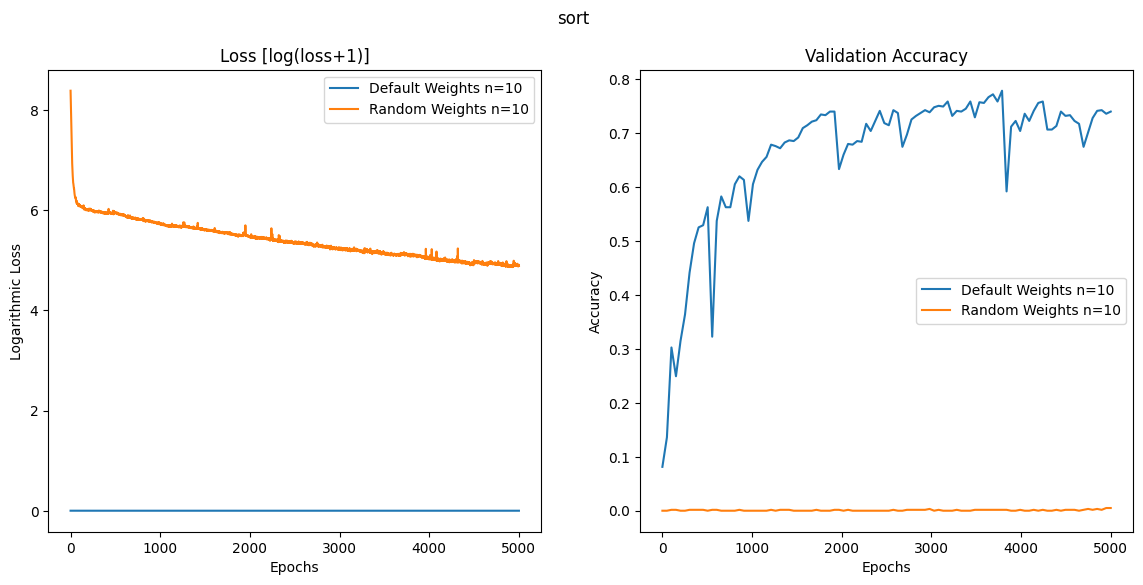

In [97]:
#Berzelius results
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/finalOvertraining/overTraining/"
displayResults(baseDirectory, "sort", displayRandom=True, consideredVersions=[2])

#Local results
baseDirectory = "tempData/"
displayResults(baseDirectory, "sort", displayRandom=True, consideredVersions=[2], n_epochs=5000)

In [7]:
#Assumes models are saved in standard format
def newDisplayResults(baseDirectory, modelName, displayDefault = True, displayRandom = False, consideredVersions = [1,2,3] ,figsize=(14,6), n_epochs = 50000, 
                      combinePlots = False, useLogLoss = True, customTitle = None):
    f = 4   #Factor which avoids index of of bounds when combining plots
    if combinePlots:
        fig, axs = plt.subplots(1,2, figsize=figsize)
        f = 2
    else:
        if figsize == (14,6):
            figsize = (14,12)
        fig, axs = plt.subplots(2,2, figsize=figsize)
        axs = [axs[0][0], axs[0][1], axs[1][0], axs[1][1]] #Flatten
    legends = [[],[],[],[]]
    for v in consideredVersions:
        if displayDefault:
            #Training Loss
            legends[0].append("Training - Default Weights n="+str(v*5))
            loss = loadArray(baseDirectory + "train_" + modelName +"_loss_v"+str(v))
            if useLogLoss:
                loss = np.log10(loss+1)
            axs[0].plot(np.linspace(0, n_epochs, len(loss)), loss)
            #Training Accuracy
            legends[1].append("Training - Default Weights n="+str(v*5))
            acc = loadArray(baseDirectory + "train_" + modelName +"_acc_v"+str(v))
            axs[1].plot(np.linspace(0, n_epochs, len(acc)), acc)
            #Validation Loss
            legends[2%f].append("Validation - Default Weights n="+str(v*5))
            loss = loadArray(baseDirectory + "val_" + modelName +"_loss_v"+str(v))
            if useLogLoss:
                loss = np.log10(loss+1)
            axs[2%f].plot(np.linspace(0, n_epochs, len(loss)), loss)
            #Validation Accuracy
            legends[3%f].append("Validation - Default Weights n="+str(v*5))
            acc = loadArray(baseDirectory + "val_" + modelName +"_acc_v"+str(v))
            axs[3%f].plot(np.linspace(0, n_epochs, len(acc)), acc)

        if displayRandom:
            #Training Loss
            legends[0].append("Training - Random Weights n="+str(v*5))
            loss = loadArray(baseDirectory + "random_" + "train_" + modelName +"_loss_v"+str(v))
            if useLogLoss:
                loss = np.log10(loss+1)
            axs[0].plot(np.linspace(0, n_epochs, len(loss)), loss)
            #Training Accuracy
            legends[1].append("Training - Random Weights n="+str(v*5))
            acc = loadArray(baseDirectory + "random_" + "train_" + modelName +"_acc_v"+str(v))
            axs[1].plot(np.linspace(0, n_epochs, len(acc)), acc)
            #Validation Loss
            legends[2%f].append("Validation - Random Weights n="+str(v*5))
            loss = loadArray(baseDirectory + "random_" + "val_" + modelName +"_loss_v"+str(v))
            if useLogLoss:
                loss = np.log10(loss+1)
            axs[2%f].plot(np.linspace(0, n_epochs, len(loss)), loss)
            #Validation Accuracy
            legends[3%f].append("Validation - Random Weights n="+str(v*5))
            acc = loadArray(baseDirectory + "random_" + "val_" + modelName +"_acc_v"+str(v))
            axs[3%f].plot(np.linspace(0, n_epochs, len(acc)), acc)

    if combinePlots:
        axs[0].set_title("Loss")
        if useLogLoss:
            axs[0].set(xlabel="Epochs", ylabel="Logarithmic Loss [log(loss+1)]")
        else:  
            axs[0].set(xlabel="Epochs", ylabel="Loss")
        axs[0].legend(legends[0]+legends[1]+legends[2]+legends[3])#
        axs[1].set_title("Accuracy")
        axs[1].set(xlabel="Epochs", ylabel="Accuracy")
        axs[1].legend(legends[0]+legends[1]+legends[2]+legends[3])
    else:
        axs[0].set_title("Training Loss")
        if useLogLoss:
            axs[0].set(xlabel="Epochs", ylabel="Logarithmic Loss [log(loss+1)]")
        else:  
            axs[0].set(xlabel="Epochs", ylabel="Loss")
        axs[0].legend(legends[0])
        axs[1].set_title("Training Accuracy")
        axs[1].set(xlabel="Epochs", ylabel="Accuracy")
        axs[1].legend(legends[1])
        axs[2].set_title("Validation Loss")
        if useLogLoss:
            axs[2].set(xlabel="Epochs", ylabel="Logarithmic Loss [log(loss+1)]")
        else:  
            axs[2].set(xlabel="Epochs", ylabel="Loss")
        axs[2].legend(legends[2])
        axs[3].set_title("Validation Accuracy")
        axs[3].set(xlabel="Epochs", ylabel="Accuracy")
        axs[3].legend(legends[3])
    if customTitle:
        fig.suptitle(customTitle)
    else:
        fig.suptitle(modelName)

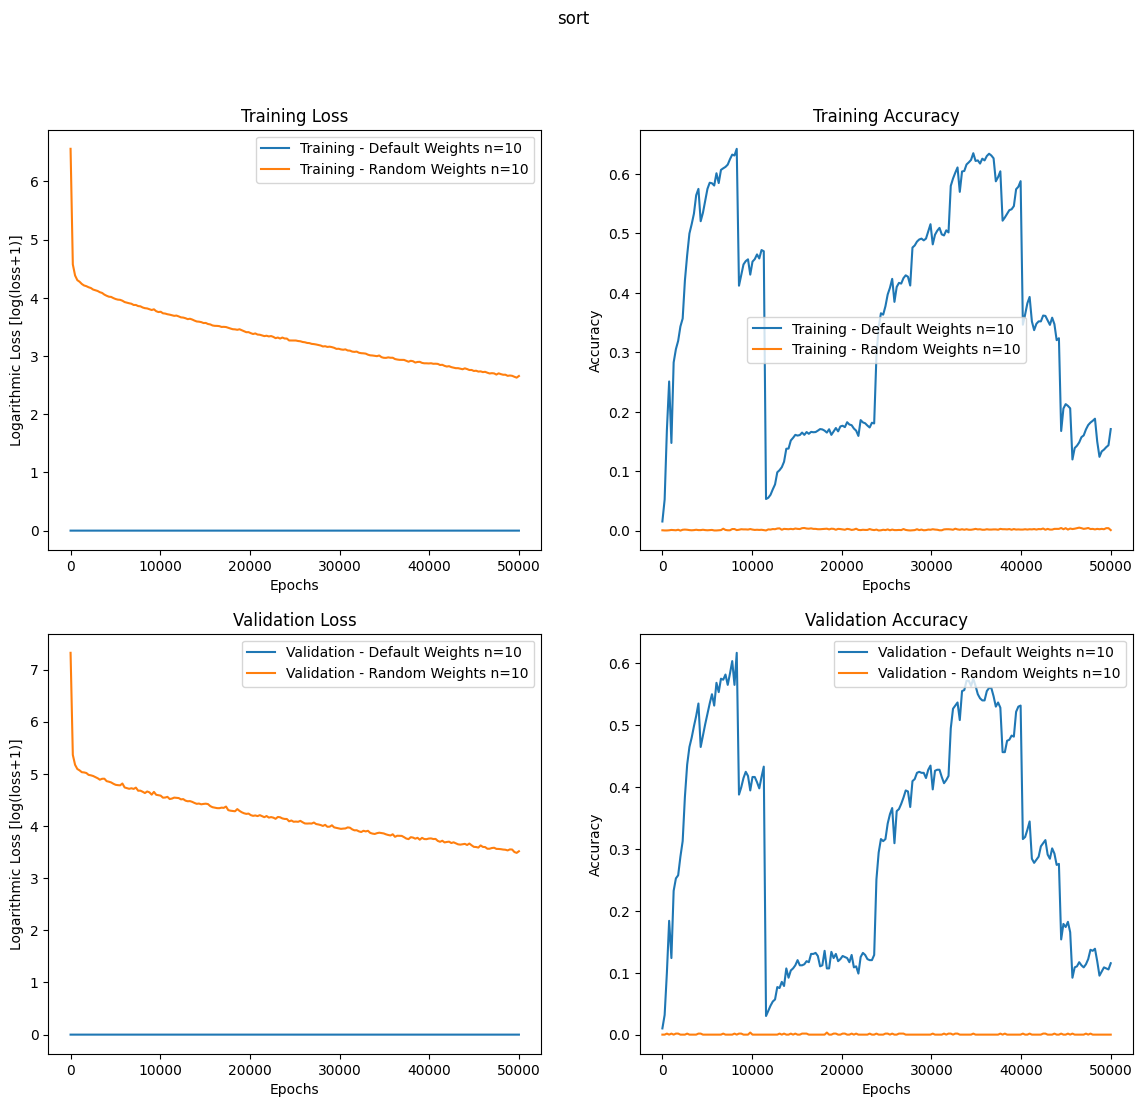

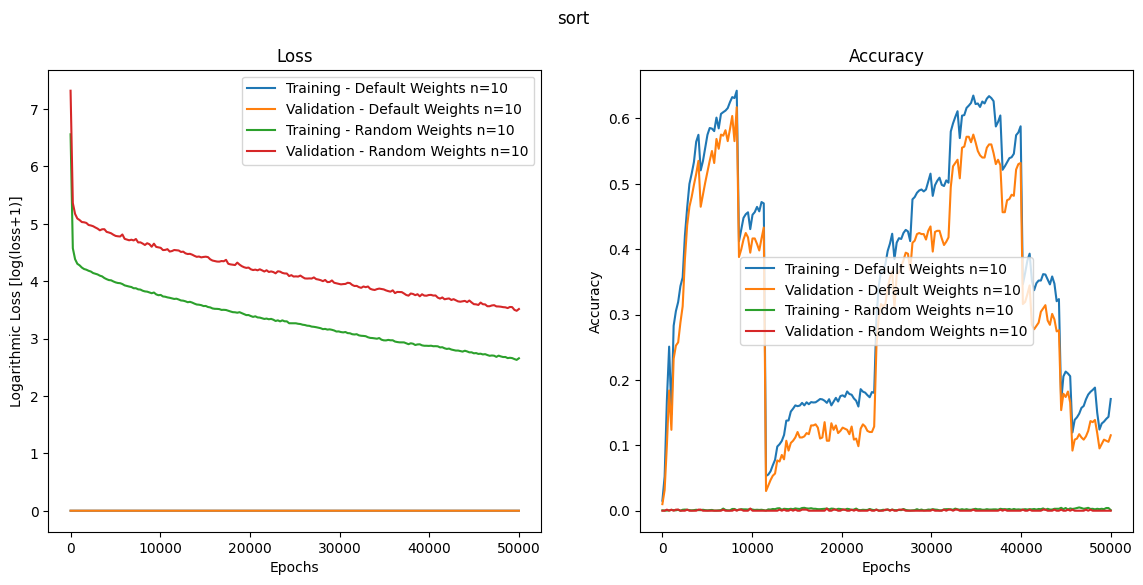

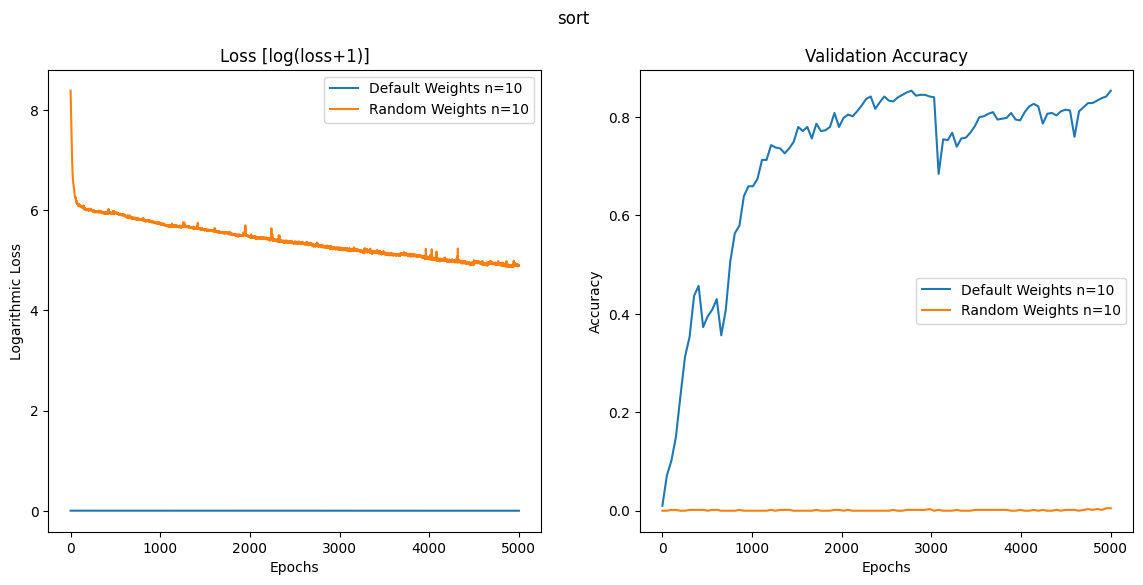

In [135]:
#Berzelius results fix test
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/finalOvertraining/testData/"
newDisplayResults(baseDirectory, "sort", displayDefault=True, displayRandom=True, consideredVersions=[2])
newDisplayResults(baseDirectory, "sort", displayDefault=True, displayRandom=True, consideredVersions=[2], combinePlots=True)

#Local results
baseDirectory = "tempData/"
displayResults(baseDirectory, "sort", displayRandom=True, consideredVersions=[2], n_epochs=5000)

## Displaying the latest data from overtraining

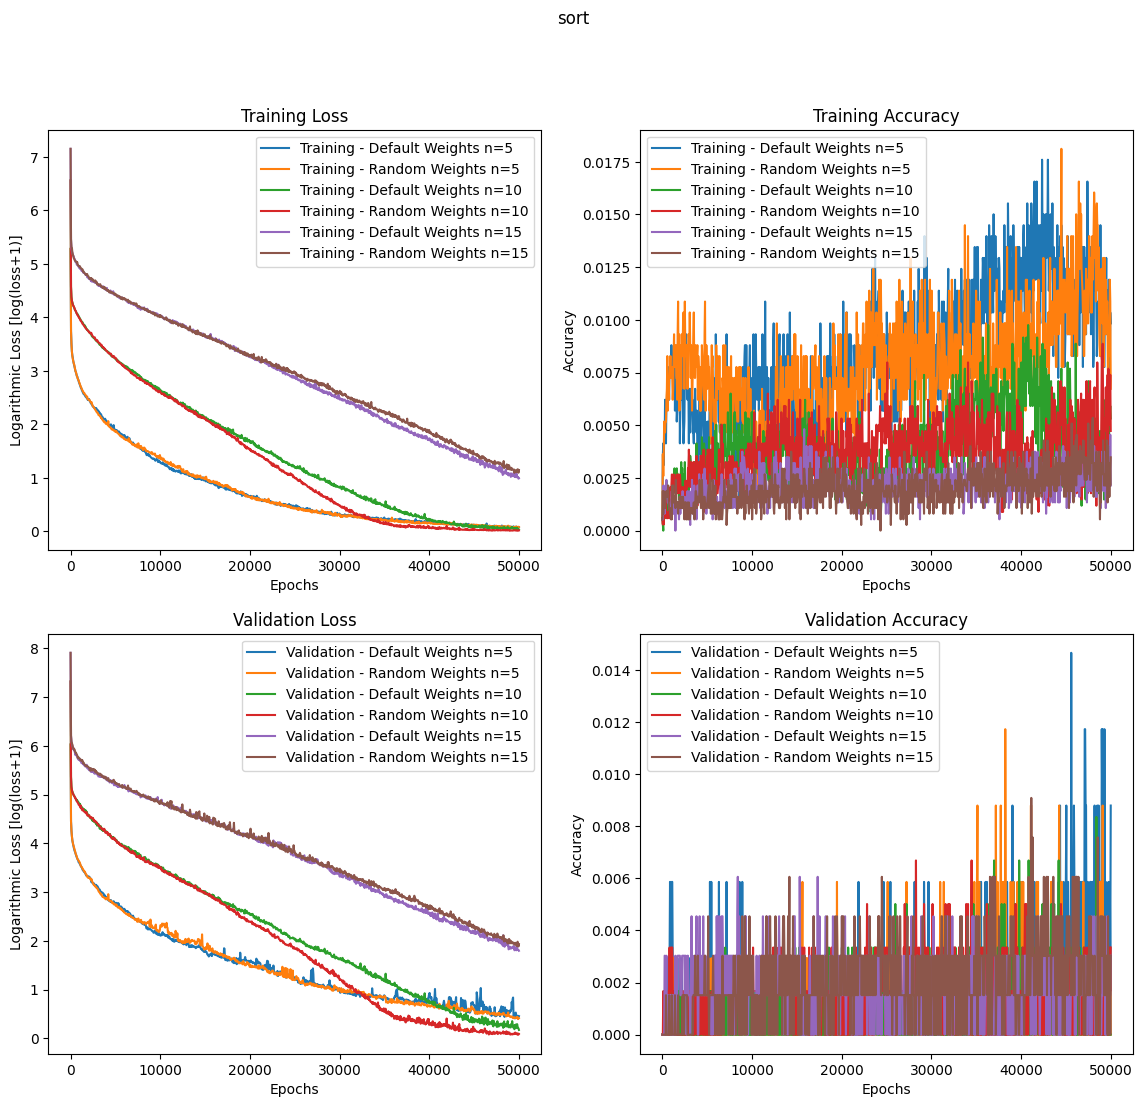

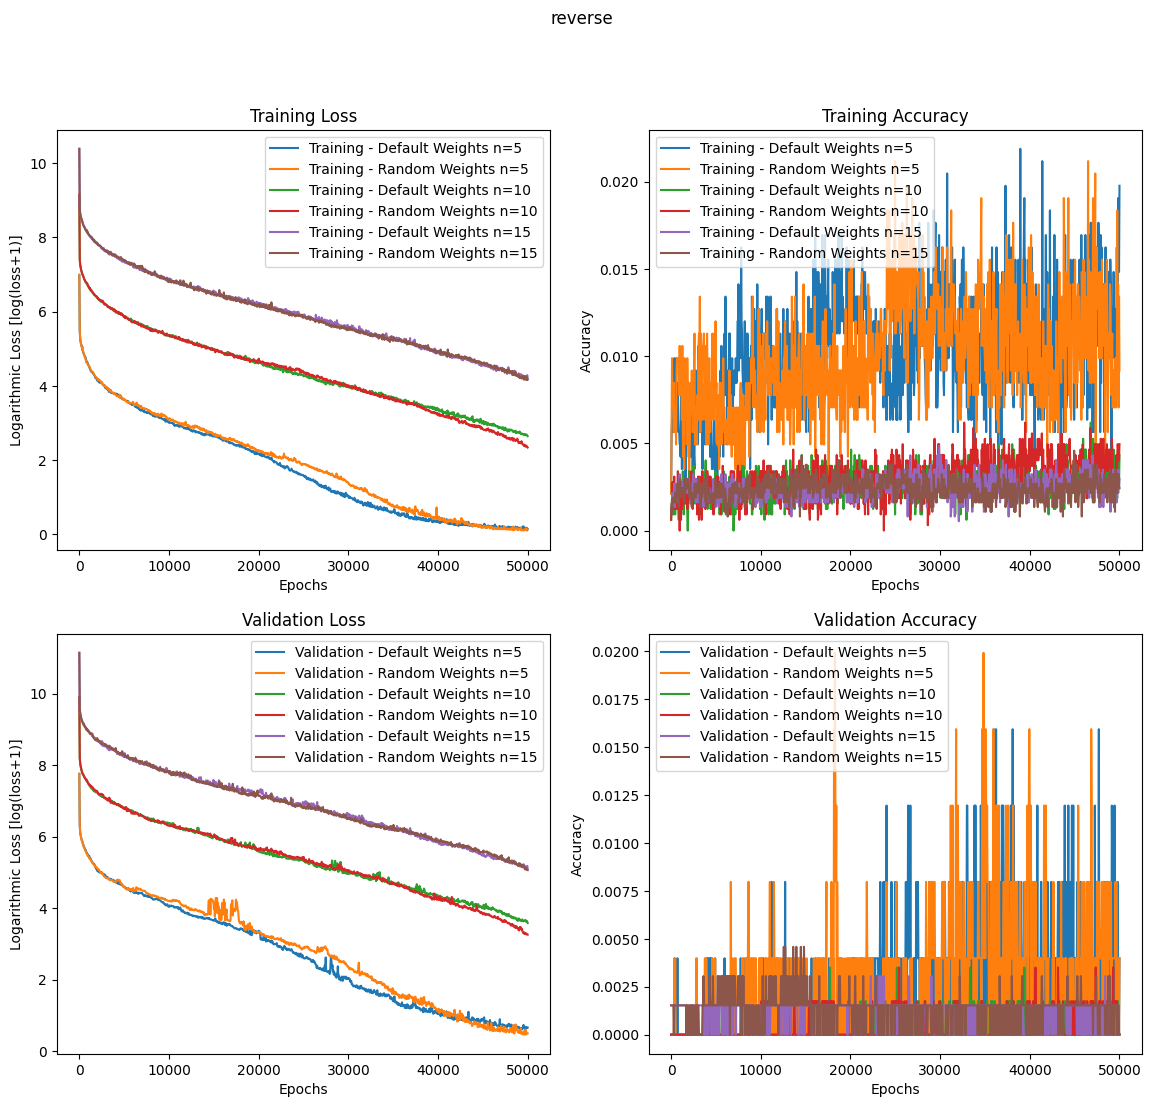

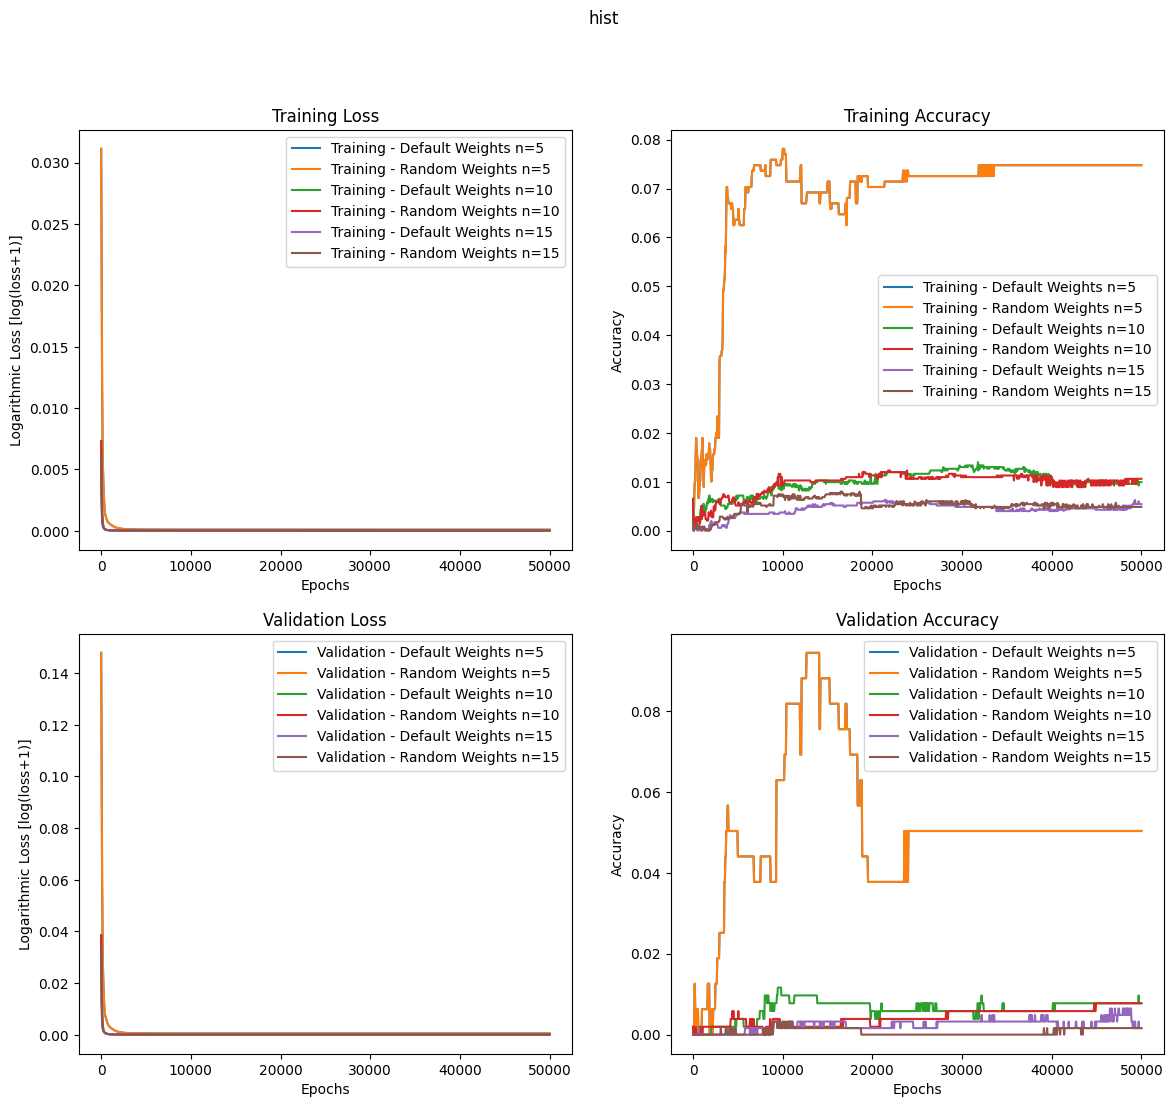

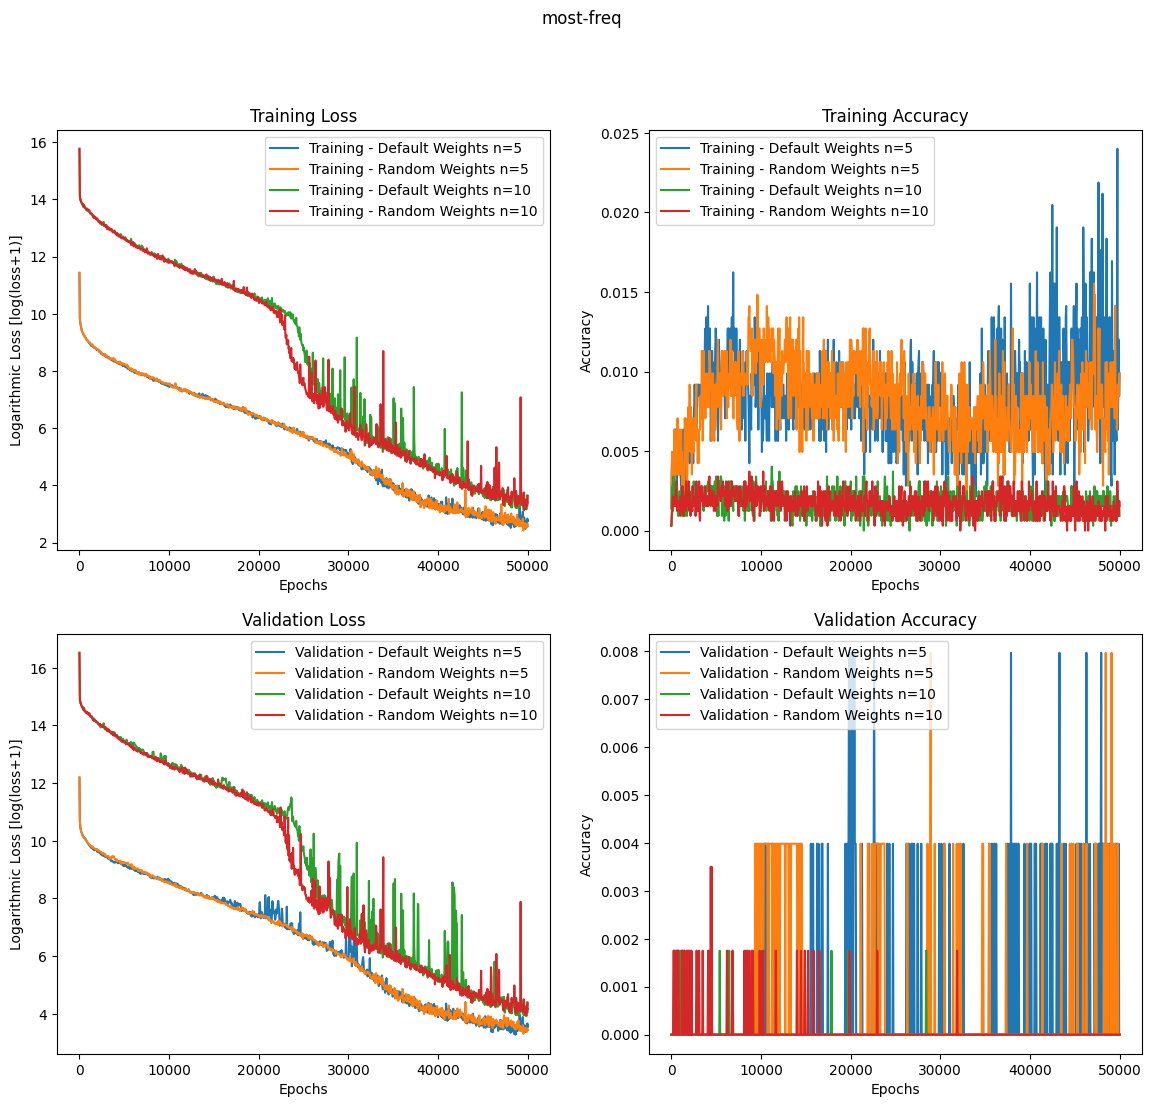

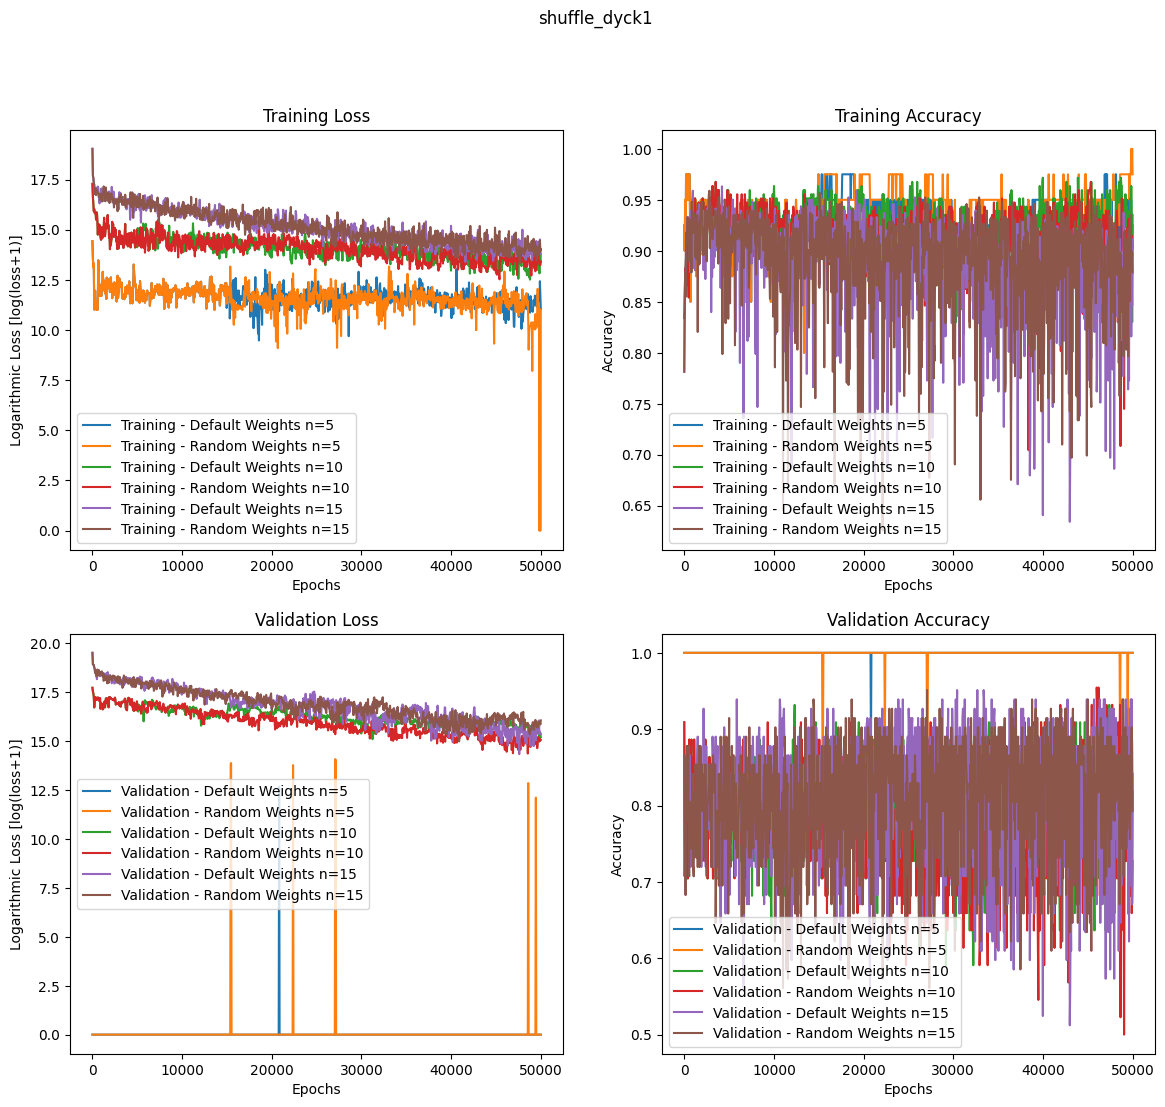

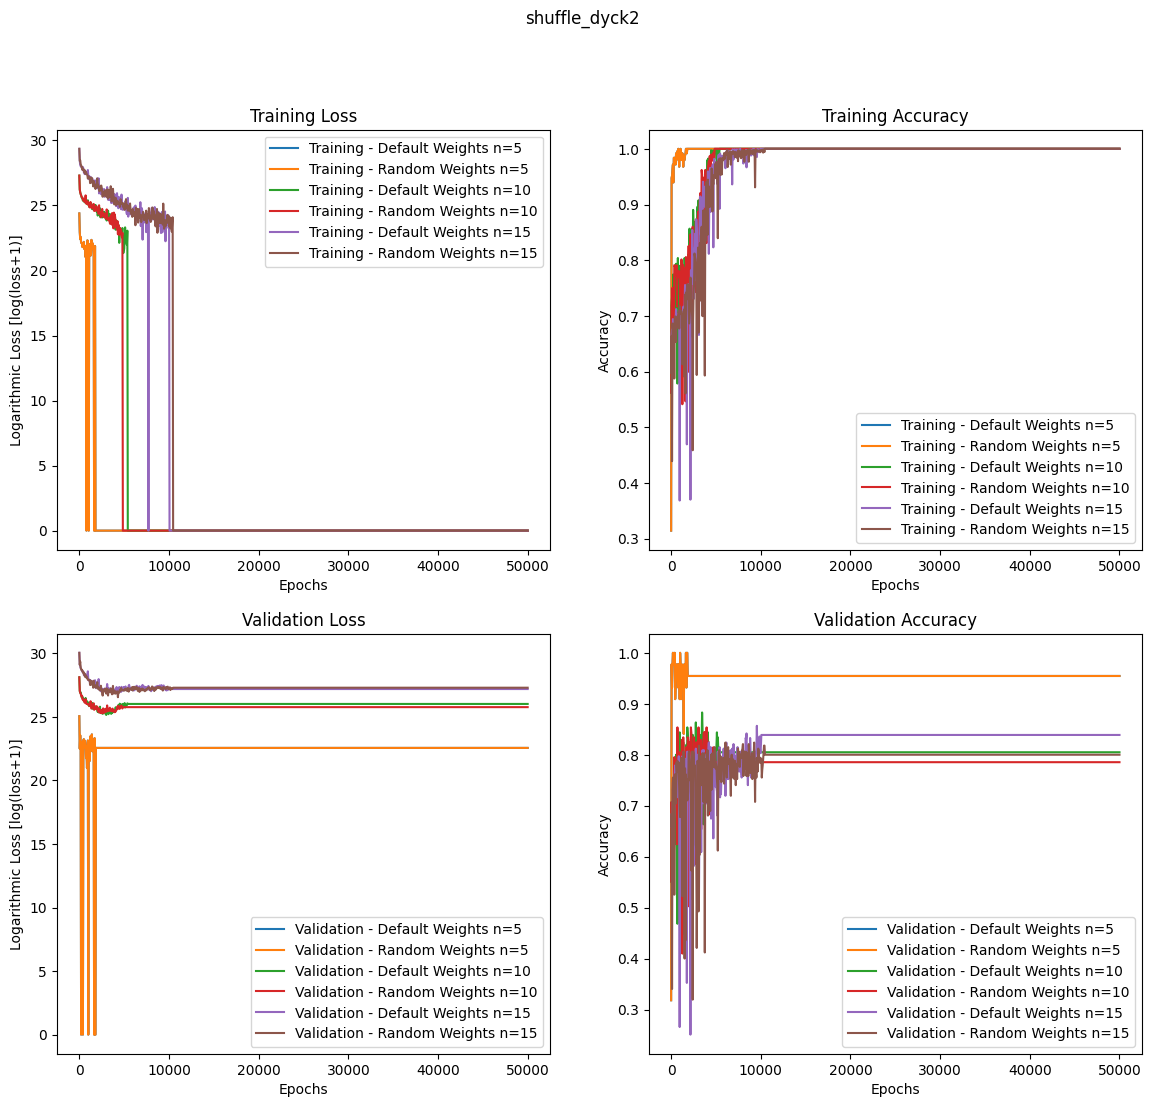

In [146]:
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/overTrainingV2/"
#newDisplayResults(baseDirectory, "sort", displayDefault=True, displayRandom=True, consideredVersions=[2])
newDisplayResults(baseDirectory, "sort", displayDefault=True, displayRandom=True, consideredVersions=[1,2,3], combinePlots=False)
newDisplayResults(baseDirectory, "reverse", displayDefault=True, displayRandom=True, consideredVersions=[1,2,3], combinePlots=False)
newDisplayResults(baseDirectory, "hist", displayDefault=True, displayRandom=True, consideredVersions=[1,2,3], combinePlots=False)
newDisplayResults(baseDirectory, "most-freq", displayDefault=True, displayRandom=True, consideredVersions=[1,2], combinePlots=False)
#NOTE most-freq_v3 aka maxLength=15 times out. I needed at least 8 hours but I only allocated 6 (Once bug is found I'll just run this one manually)
newDisplayResults(baseDirectory, "shuffle_dyck1", displayDefault=True, displayRandom=True, consideredVersions=[1,2,3], combinePlots=False)
newDisplayResults(baseDirectory, "shuffle_dyck2", displayDefault=True, displayRandom=True, consideredVersions=[1,2,3], combinePlots=False)

## Sort with trainer classs

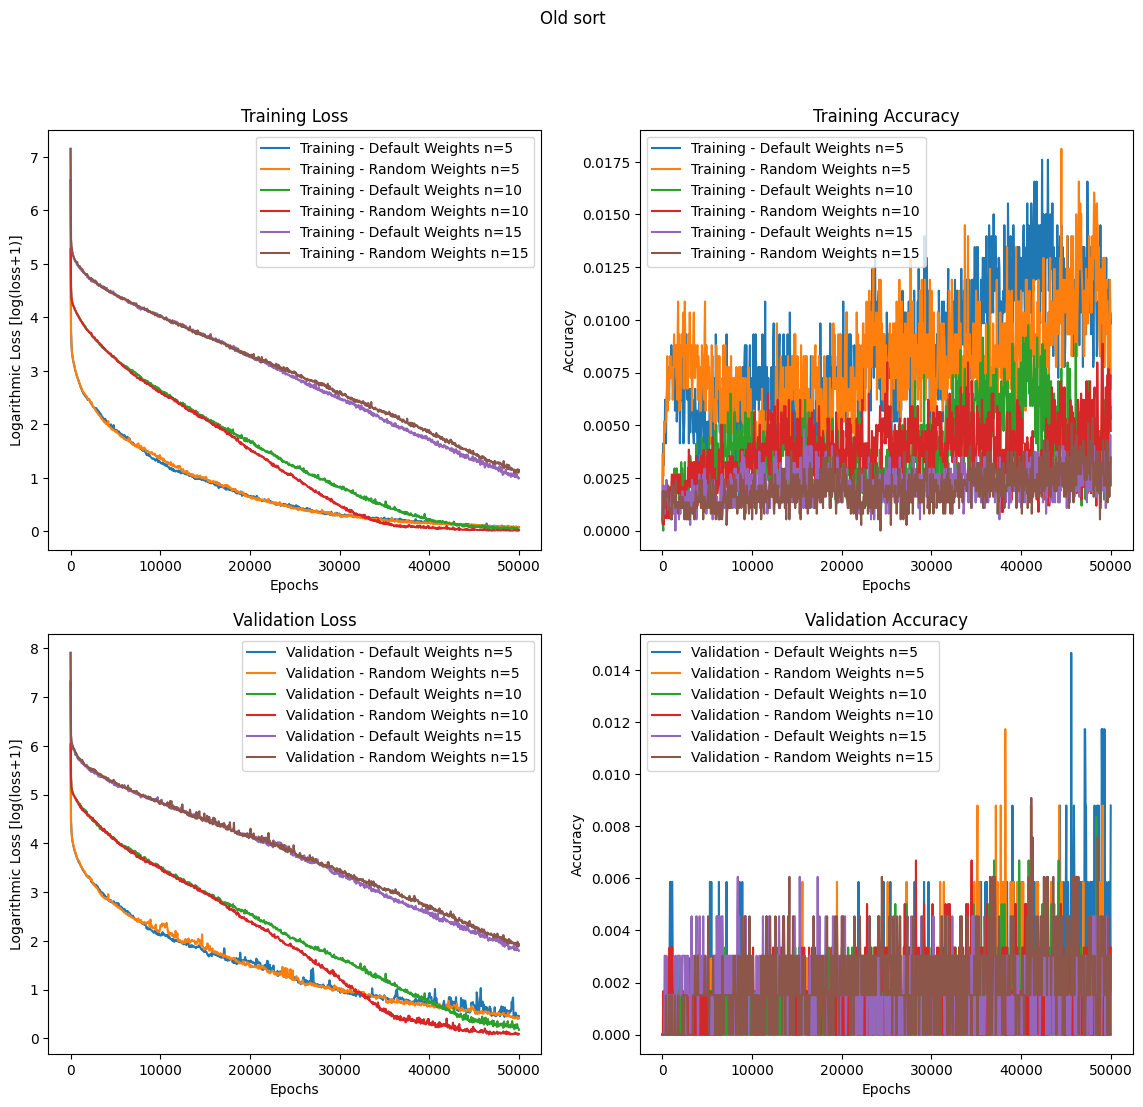

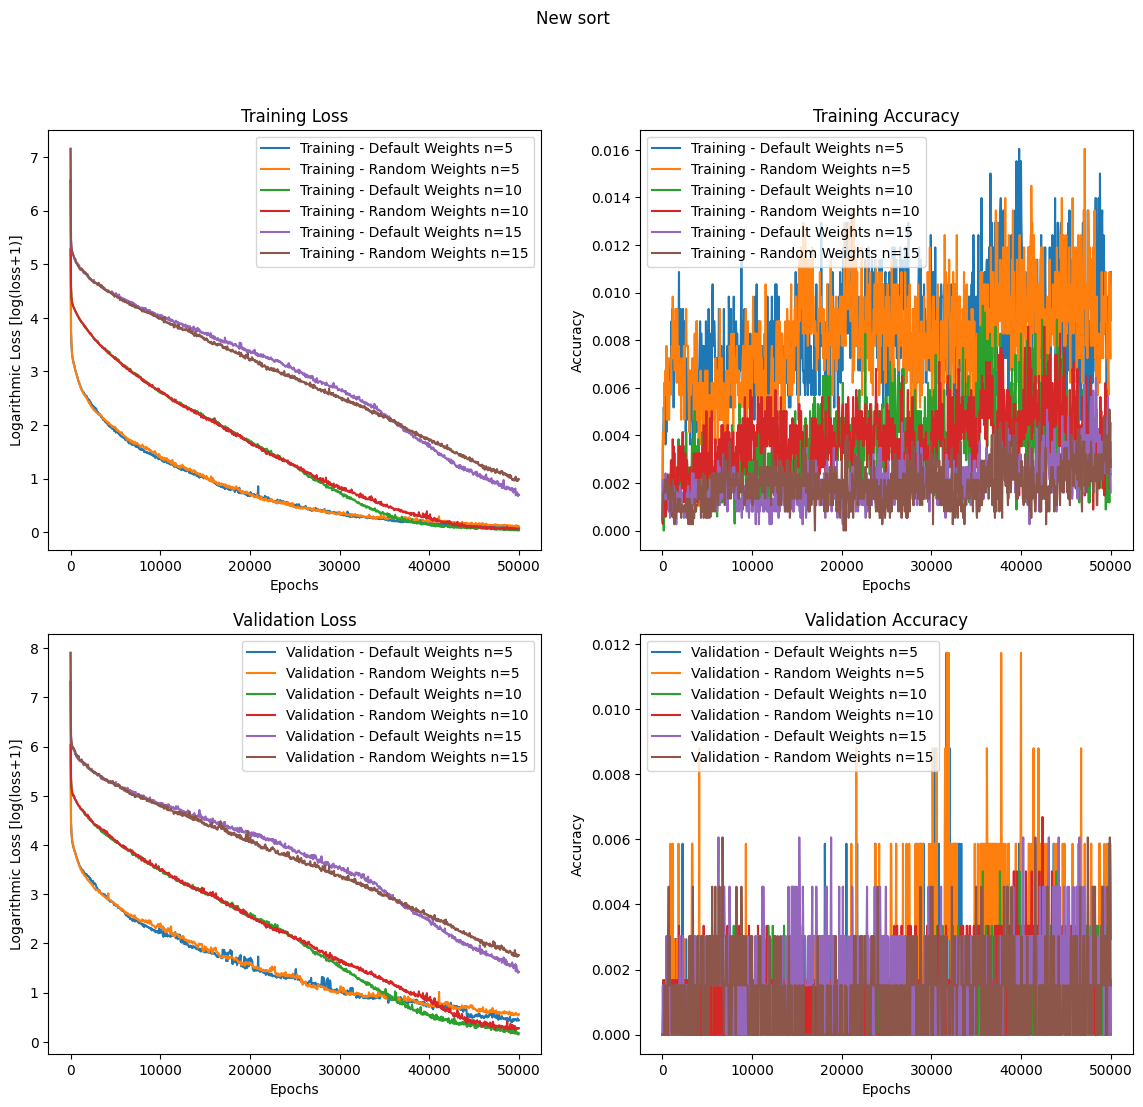

In [8]:
#Old results for convenience
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/overTrainingV2/"
newDisplayResults(baseDirectory, "sort", displayDefault=True, displayRandom=True, consideredVersions=[1,2,3], combinePlots=False, customTitle="Old sort")

#New results
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/overTrainingV3/"
newDisplayResults(baseDirectory, "sort", displayDefault=True, displayRandom=True, consideredVersions=[1,2,3], combinePlots=False, customTitle="New sort")